In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *

import json
from utils import *

In [3]:
PATH = Path('../data/quickdraw/')

In [4]:
PATH.ls()

[PosixPath('../data/quickdraw/test_simplified.csv'),
 PosixPath('../data/quickdraw/train'),
 PosixPath('../data/quickdraw/submission'),
 PosixPath('../data/quickdraw/train_folders'),
 PosixPath('../data/quickdraw/dummy_train_folders'),
 PosixPath('../data/quickdraw/dfs_combined.csv'),
 PosixPath('../data/quickdraw/classes.pkl'),
 PosixPath('../data/quickdraw/test')]

In [5]:
dfs_combined = pd.read_csv(PATH/"dfs_combined.csv")

In [6]:
dfs_combined = dfs_combined[['drawing', 'word']]

In [7]:
dfs_combined.shape[0]//340

99930

In [8]:
def get_raw_stroke_parts(raw_strokes):
    if isinstance(raw_strokes, str): raw_strokes = eval(raw_strokes)
    n = len(raw_strokes)
    if n == 1:
        return [[raw_strokes[0]], None, None]
    elif n == 2:
        return [[raw_strokes[0]], [raw_strokes[1]], None]
    else:
        div, _ = divmod(n, 3)
        return [raw_strokes[:div], raw_strokes[div:div*2], raw_strokes[div*2:]]

In [9]:
def list2drawing(raw_strokes, size=256, lw=6, time_color=False):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    else:
        return img

In [10]:
def raw_stroke_parts2drawing(raw_stroke_parts, sum_as_final=False, color=False):
    img = []
    for raw_stroke in raw_stroke_parts:
        if raw_stroke is not None:
            img.append(list2drawing(raw_stroke, 256, lw=2, time_color=color))
        else:
            img.append(np.zeros((256, 256)))
    if sum_as_final:
        img[2] = img[0] + img[1] + img[2]
    return np.array(img)

In [11]:
def list2drawing_3channels(raw_strokes, sum_as_final, color):
    return raw_stroke_parts2drawing(get_raw_stroke_parts(raw_strokes), sum_as_final, color)

In [70]:
dfs_combined['word'] = dfs_combined['word'].apply(lambda x: x.replace(" ", "_"))

In [72]:
classes = dfs_combined['word'].unique()

In [75]:
for c in classes:
    break

In [78]:
class_drawings = dfs_combined[dfs_combined['word'] == c]['drawing']

In [96]:
folder_path = PATH/f"train_folders/{c}"

In [97]:
os.makedirs(folder_path, exist_ok=True)

In [98]:
folder_path

PosixPath('../data/quickdraw/train_folders/wine_bottle')

In [112]:
i_drawings = [[folder_path] + list(*p) for p in list(zip(enumerate(class_drawings)))]

In [113]:
i_drawings[0]

[PosixPath('../data/quickdraw/train_folders/wine_bottle'),
 0,
 '[[[47, 41, 40, 9, 3, 0, 0, 9, 11, 17, 23, 31, 110, 127, 127, 113], [0, 8, 79, 92, 101, 118, 156, 179, 194, 202, 249, 255, 255, 250, 235, 188]]]']

In [132]:
i_drawings = i_drawings[:20]

In [133]:
def save_img(save_path, i, drawing):
    raw_stroke_parts = get_raw_stroke_parts(drawing)
    img = raw_stroke_parts2drawing(raw_stroke_parts, sum_as_final=True, color=True)
    pil_img = Image.fromarray(np.rollaxis(img, 0, 3).astype(dtype=np.uint8))
    pil_img.save(save_path/f"img_{i}.png", format='png')

In [134]:
save_img(*i_drawings[0])

In [135]:
with ThreadPoolExecutor(max_workers=8) as e:
    e.map(lambda p: save_img(*p), i_drawings)

In [136]:
0.4*340

136.0

### show images

In [139]:
train_folders = (PATH/'train_folders').ls()

../data/quickdraw/train_folders/light_bulb/img_44911.png


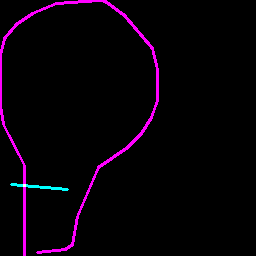

In [206]:
i = np.random.choice(range(len(train_folders)))
rand_img_path = np.random.choice(train_folders[i].ls())
print(rand_img_path)
open_image(rand_img_path)